In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.ndimage import gaussian_filter
from scipy.stats import weibull_min, t
from scipy.optimize import curve_fit

# Loading data

In [2]:
prices_1 = pd.read_csv('data/1/prices_round_1_day_-2.csv', delimiter=';').drop(columns=['day', 'profit_and_loss'])
prices_2 = pd.read_csv('data/1/prices_round_1_day_-1.csv', delimiter=';').drop(columns=['day', 'profit_and_loss'])
prices_3 = pd.read_csv('data/1/prices_round_1_day_0.csv', delimiter=';').drop(columns=['day', 'profit_and_loss'])

pa1 = prices_1[prices_1['product'] == 'AMETHYSTS'].set_index('timestamp', drop=True).drop(columns=['product'])
pa2 = prices_2[prices_2['product'] == 'AMETHYSTS'].set_index('timestamp', drop=True).drop(columns=['product'])
pa3 = prices_3[prices_3['product'] == 'AMETHYSTS'].set_index('timestamp', drop=True).drop(columns=['product'])

ps1 = prices_1[prices_1['product'] == 'STARFRUIT'].set_index('timestamp', drop=True).drop(columns=['product'])
ps2 = prices_2[prices_2['product'] == 'STARFRUIT'].set_index('timestamp', drop=True).drop(columns=['product'])
ps3 = prices_3[prices_3['product'] == 'STARFRUIT'].set_index('timestamp', drop=True).drop(columns=['product'])

In [3]:
trades_1 = pd.read_csv('data/1/trades_round_1_day_-2_nn.csv', delimiter=';').drop(columns=['buyer', 'seller', 'currency'])
trades_2 = pd.read_csv('data/1/trades_round_1_day_-1_nn.csv', delimiter=';').drop(columns=['buyer', 'seller', 'currency'])
trades_3 = pd.read_csv('data/1/trades_round_1_day_0_nn.csv', delimiter=';').drop(columns=['buyer', 'seller', 'currency'])

ta1 = trades_1[trades_1['symbol'] == 'AMETHYSTS'].set_index('timestamp', drop=True).drop(columns=['symbol'])
ta2 = trades_2[trades_2['symbol'] == 'AMETHYSTS'].set_index('timestamp', drop=True).drop(columns=['symbol'])
ta3 = trades_3[trades_3['symbol'] == 'AMETHYSTS'].set_index('timestamp', drop=True).drop(columns=['symbol'])

ts1 = trades_1[trades_1['symbol'] == 'STARFRUIT'].set_index('timestamp', drop=True).drop(columns=['symbol'])
ts2 = trades_2[trades_2['symbol'] == 'STARFRUIT'].set_index('timestamp', drop=True).drop(columns=['symbol'])
ts3 = trades_3[trades_3['symbol'] == 'STARFRUIT'].set_index('timestamp', drop=True).drop(columns=['symbol'])

# AMETHYSTS

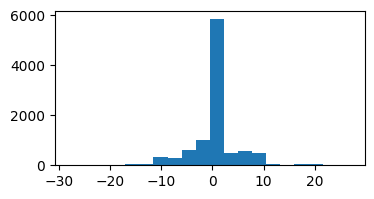

In [15]:
orderflow_imbalance = pa1['bid_volume_1'].fillna(0) + pa1['bid_volume_2'].fillna(0) + pa1['bid_volume_3'].fillna(0) -\
pa1['ask_volume_1'].fillna(0) - pa1['ask_volume_2'].fillna(0) -pa1['ask_volume_3'].fillna(0)

plt.figure(figsize=(4, 2))
plt.hist(orderflow_imbalance, 20)
plt.show()

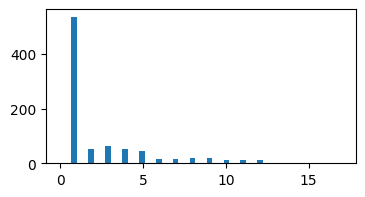

In [706]:
plt.figure(figsize=(4, 2))
plt.hist(pa1[pa1['bid_price_1'] > 10000]['bid_volume_1'], bins=50)
plt.show()

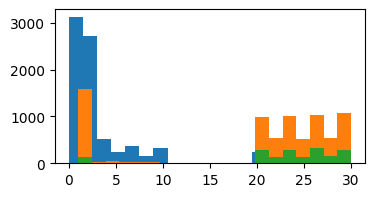

In [713]:
plt.figure(figsize=(4, 2))
plt.hist(pa1['bid_volume_1'], bins=20)
plt.hist(pa1['bid_volume_2'], bins=20)
plt.hist(pa1['bid_volume_3'], bins=20)
plt.show()

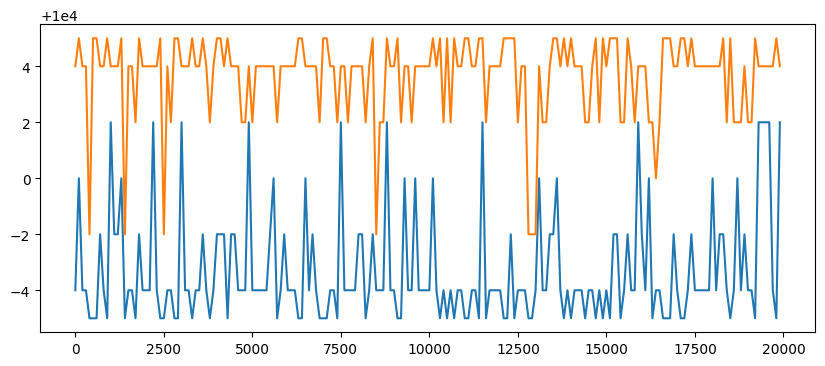

In [678]:
plt.figure(figsize=(10, 4))
plt.plot(pa1['bid_price_1'].iloc[:200])
plt.plot(pa1['ask_price_1'].iloc[:200])
plt.show()

## Volatility

In [657]:
pa1['mid_price'].std() / pa1['mid_price'].mean(), pa2['mid_price'].std() / pa2['mid_price'].mean(), pa3['mid_price'].std() / pa3['mid_price'].mean()

(0.00015138412458019386, 0.00014796080285416362, 0.00014962282310248268)

## Spread

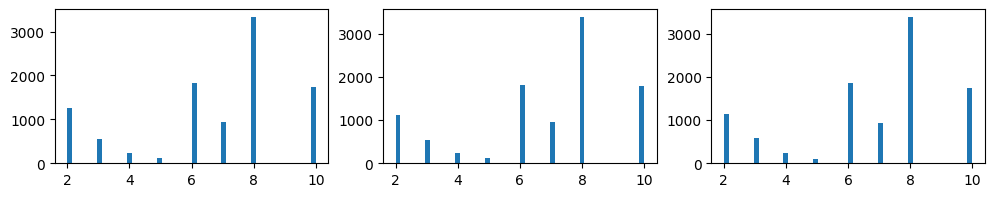

In [658]:
fig, ax = plt.subplots(1, 3, figsize=(12, 2))
ax[0].hist(pa1['ask_price_1'] - pa1['bid_price_1'], bins=50)
ax[1].hist(pa2['ask_price_1'] - pa2['bid_price_1'], bins=50)
ax[2].hist(pa3['ask_price_1'] - pa3['bid_price_1'], bins=50)
plt.show()

## Trades

In [666]:
ta1['quantity'].max(), ta2['quantity'].max(), ta3['quantity'].max()

(12, 12, 12)

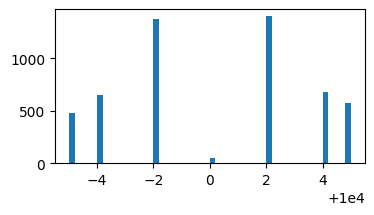

In [660]:
plt.figure(figsize=(4, 2))
plt.hist(ta1['price'], weights=ta1['quantity'], bins=50)
plt.show()

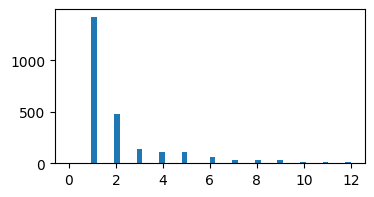

In [6]:
plt.figure(figsize=(4, 2))
plt.hist(ta1['quantity'], bins=50)
plt.show()

In [7]:
prob = {}
fair_value = 10000
for p in range(fair_value - 6, fair_value ):
    prob[p] = ta1[ta1['price'] == p]['quantity'].sum() / ta1[ta1['price'] < fair_value]['quantity'].sum()
prob

{9994: 0.0,
 9995: 0.19059107358262967,
 9996: 0.25934861278648974,
 9997: 0.0,
 9998: 0.5500603136308806,
 9999: 0.0}

In [9]:
ev = {}
for k, e in prob.items():
    ev[k] = e * np.abs(fair_value - k)
s = np.sum(list(ev.values()))
for k in ev.keys():
    ev[k] = ev[k] / s
ev

{9994: 0.0,
 9995: 0.3083528493364559,
 9996: 0.3356752537080406,
 9997: 0.0,
 9998: 0.3559718969555035,
 9999: 0.0}

In [10]:
np.sum(list(ev.values()))

1.0

In [11]:
for k, e in ev.items():
    print(f'{k}: {round(e * 20)}')

9994: 0
9995: 6
9996: 7
9997: 0
9998: 7
9999: 0


In [12]:
20 * 0.2 * 5, 20 * 0.24 * 4, 20 * 0.56 * 2

(20.0, 19.2, 22.400000000000002)

In [13]:
0 * 0.2 * 5 + 0 * 0.24 * 4 + 20 * 0.56 * 2

22.400000000000002

In [14]:
10 * 2 / (10 * 2 + 12 * 4 + 28 * 5), 12 * 4  / (10 * 2 + 12 * 4 + 28 * 5), 28 * 5  / (10 * 2 + 12 * 4 + 28 * 5)

(0.09615384615384616, 0.23076923076923078, 0.6730769230769231)

In [15]:
0.09615384615384616 * 20, 0.23076923076923078 * 20, 0.6730769230769231 * 20

(1.9230769230769231, 4.615384615384616, 13.461538461538463)

In [16]:
2 * 0.2 * 5 + 5 * 0.24 * 4 + 13 * 0.56 * 2

21.360000000000003

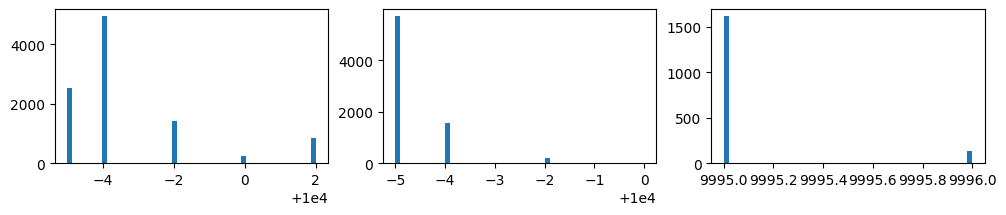

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(12, 2))
ax[0].hist(pa1['bid_price_1'], bins=50)
ax[1].hist(pa1['bid_price_2'], bins=50)
ax[2].hist(pa1['bid_price_3'], bins=50)
plt.show()

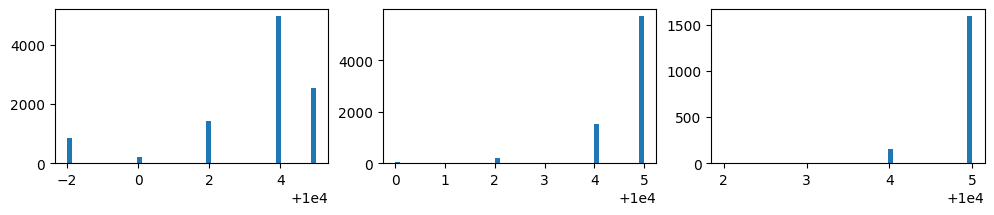

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(12, 2))
ax[0].hist(pa1['ask_price_1'], bins=50)
ax[1].hist(pa1['ask_price_2'], bins=50)
ax[2].hist(pa1['ask_price_3'], bins=50)
plt.show()

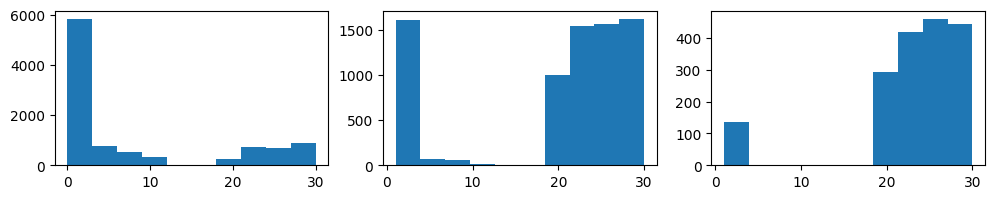

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(12, 2))
ax[0].hist(pa1['bid_volume_1'], bins=10)
ax[1].hist(pa1['bid_volume_2'], bins=10)
ax[2].hist(pa1['bid_volume_3'], bins=10)
plt.show()

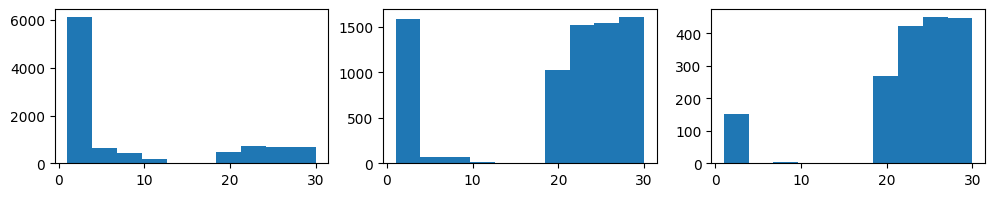

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(12, 2))
ax[0].hist(pa1['ask_volume_1'], bins=10)
ax[1].hist(pa1['ask_volume_2'], bins=10)
ax[2].hist(pa1['ask_volume_3'], bins=10)
plt.show()

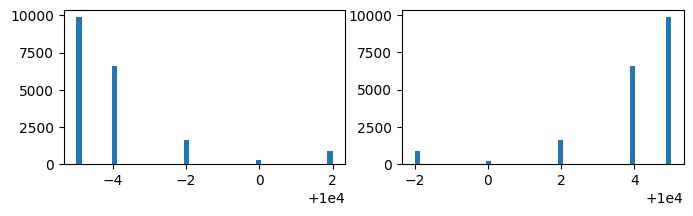

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(8, 2))
ax[0].hist(pd.concat([pa1['bid_price_1'], pa1['bid_price_2'], pa1['bid_price_3']]), bins=50)
ax[1].hist(pd.concat([pa1['ask_price_1'], pa1['ask_price_2'], pa1['ask_price_3']]), bins=50)
plt.show()

# STARFRUIT

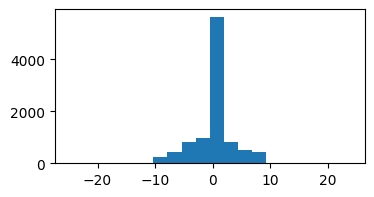

In [16]:
orderflow_imbalance = ps1['bid_volume_1'].fillna(0) + ps1['bid_volume_2'].fillna(0) + ps1['bid_volume_3'].fillna(0) -\
ps1['ask_volume_1'].fillna(0) - ps1['ask_volume_2'].fillna(0) -ps1['ask_volume_3'].fillna(0)

plt.figure(figsize=(4, 2))
plt.hist(orderflow_imbalance, 20)
plt.show()

## Price

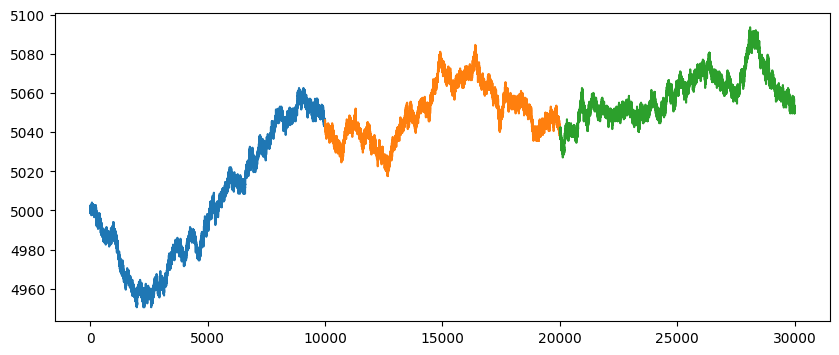

In [96]:
plt.figure(figsize=(10, 4))
plt.plot(np.arange(ps1.shape[0]), ps1['mid_price'])
plt.plot(np.arange(ps1.shape[0], ps1.shape[0] + ps2.shape[0]), ps2['mid_price'])
plt.plot(np.arange(ps1.shape[0] + ps2.shape[0], ps1.shape[0] + ps2.shape[0] + ps3.shape[0]), ps3['mid_price'])
plt.show()

## Volatility

In [22]:
ps1['mid_price'].std() / ps1['mid_price'].mean(), ps2['mid_price'].std() / ps2['mid_price'].mean(), ps3['mid_price'].std() / ps3['mid_price'].mean()

(0.0065453271288914115, 0.0026883741076796043, 0.002316312510489472)

## Spread

In [24]:
(ps1['ask_price_1'] - ps1['bid_price_1']).mean(), (ps2['ask_price_1'] - ps2['bid_price_1']).mean(), (ps3['ask_price_1'] - ps3['bid_price_1']).mean()

(5.3464, 5.4087, 5.4437)

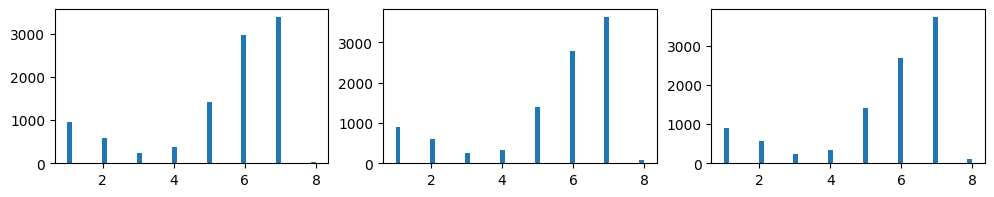

In [312]:
fig, ax = plt.subplots(1, 3, figsize=(12, 2))
ax[0].hist(ps1['ask_price_1'] - ps1['bid_price_1'], bins=50)
ax[1].hist(ps2['ask_price_1'] - ps2['bid_price_1'], bins=50)
ax[2].hist(ps3['ask_price_1'] - ps3['bid_price_1'], bins=50)
plt.show()

## Autocorrelation

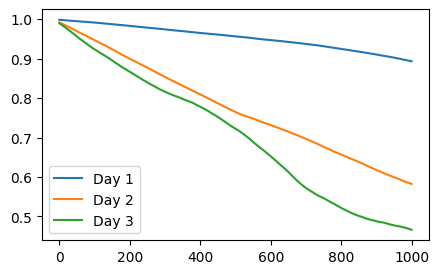

In [97]:
acf_1, acf_2, acf_3 = [], [], []
for lag in range(1, 1001):
    acf_1.append(ps1['mid_price'].autocorr(lag=lag))
    acf_2.append(ps2['mid_price'].autocorr(lag=lag))
    acf_3.append(ps3['mid_price'].autocorr(lag=lag))

plt.figure(figsize=(5, 3))
plt.plot(acf_1, label='Day 1')
plt.plot(acf_2, label='Day 2')
plt.plot(acf_3, label='Day 3')
plt.legend()
plt.show()

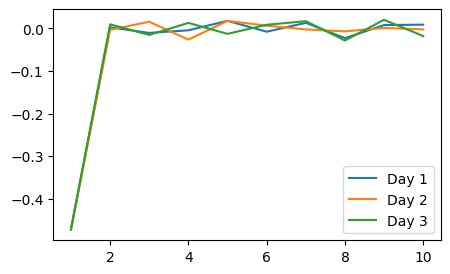

In [113]:
acf_1, acf_2, acf_3 = [], [], []
for lag in range(1, 11):
    acf_1.append(ps1['mid_price'].diff(periods=1).autocorr(lag=lag))
    acf_2.append(ps2['mid_price'].diff(periods=1).autocorr(lag=lag))
    acf_3.append(ps3['mid_price'].diff(periods=1).autocorr(lag=lag))

plt.figure(figsize=(5, 3))
plt.plot(range(1, 11), acf_1, label='Day 1')
plt.plot(range(1, 11), acf_2, label='Day 2')
plt.plot(range(1, 11), acf_3, label='Day 3')
plt.legend()
plt.show()

## Price modelling

### Brownian motion

The equation for Brownian motion is  dr=μ⋅dt+σ⋅dW, where dr is the change in the logarithmic returns, μ is the drift (mean rate of return), dt is the change in time, σ is the volatility (standard deviation of returns), and dW is a Wiener process (random noise). In discrete time, dt is a constant (e.g., 1 day).

In [481]:
log_return = np.log(ps1['mid_price']).diff().dropna()

X = sm.add_constant(np.arange(len(log_return)))
y = log_return

model = sm.OLS(y, X)
results = model.fit()

mu = results.params[1]  # Estimated drift
sigma = np.sqrt(results.mse_resid)  # Estimated volatility

print(mu, sigma)

4.55456264032884e-10 0.00034133404140745667


C:\Users\aeali\AppData\Local\Temp\ipykernel_14984\1152780720.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = results.params[1]  # Estimated drift


In [450]:
def simulate_brownian_motion(initial_price, mu, sigma, num_steps, dt=1):
    """
    Simulate Brownian motion using Geometric Brownian Motion (GBM) model.
    
    Parameters:
        initial_price (float): Initial price of the asset.
        mu (float): Drift rate.
        sigma (float): Volatility.
        num_steps (int): Number of time steps to simulate.
        dt (float): Time increment (default=1).
        
    Returns:
        prices (ndarray): Simulated asset prices.
    """
    prices = np.zeros(num_steps)
    prices[0] = initial_price
    
    for t in range(1, num_steps):
        # Generate random noise from standard normal distribution
        Z = np.random.normal()
        # Compute the next price using GBM formula
        prices[t] = prices[t - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    
    return prices

In [482]:
sigma *= 0.5

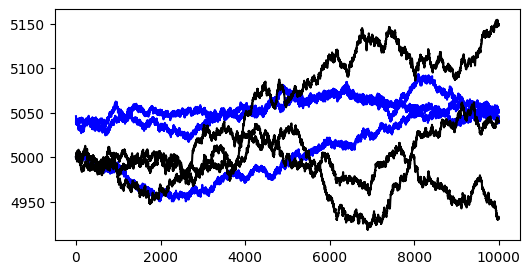

In [484]:
sim_price_1 = simulate_brownian_motion(5000, mu, sigma, 10000)
sim_price_2 = simulate_brownian_motion(5000, mu, sigma, 10000)
sim_price_3 = simulate_brownian_motion(5000, mu, sigma, 10000)

plt.figure(figsize=(6, 3))
plt.plot(ps1['mid_price'].to_numpy(), label='Day 1', c='b')
plt.plot(ps2['mid_price'].to_numpy(), label='Day 2', c='b')
plt.plot(ps3['mid_price'].to_numpy(), label='Day 3', c='b')
plt.plot(sim_price_1, label='Sim 1', c='k')
plt.plot(sim_price_2, label='Sim 1', c='k')
plt.plot(sim_price_3, label='Sim 1', c='k')
plt.show()

In [485]:
spreads = list(ps1['ask_price_1'] - ps1['bid_price_1'])

In [486]:
sim_prices = []
for _ in range(100):
    mid = simulate_brownian_motion(5000, mu, sigma, 10000)
    mid = np.round(mid * 2)/2
    spr = np.random.choice(spreads, 10000)
    bid = np.int_(mid - spr / 2)
    ask = np.int_(mid + spr / 2)
    sim_price = pd.DataFrame()
    sim_price = sim_price.assign(bid=bid).assign(ask=ask).assign(mid=lambda x: (x.bid + x.ask) / 2)
    sim_prices.append(sim_price)

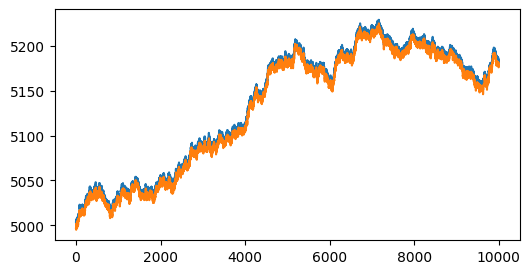

In [487]:
plt.figure(figsize=(6, 3))
plt.plot(sim_prices[37]['ask'])
plt.plot(sim_prices[37]['bid'])
plt.show()

### Student's t-distribution

In [338]:
def students_t_pdf(x, nu, mu, std):
    return t.pdf(x, df=nu, loc=mu, scale=std)

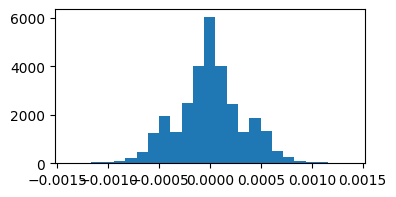

In [343]:
returns = np.log(ps1['mid_price'] / ps1['mid_price'].shift(1)).dropna()
returns = pd.concat([returns, np.log(ps2['mid_price'] / ps2['mid_price'].shift(1)).dropna()])
returns = pd.concat([returns, np.log(ps3['mid_price'] / ps3['mid_price'].shift(1)).dropna()])
n_bins = 25

plt.figure(figsize=(4, 2))
plt.hist(returns, bins=n_bins)
plt.show()

In [344]:
hist, bin_edges = np.histogram(returns, bins=n_bins, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_width = bin_edges[1] - bin_edges[0]

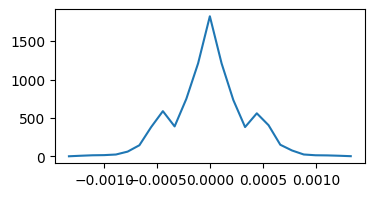

In [345]:
plt.figure(figsize=(4, 2))
plt.plot(bin_centers, hist)
plt.show()

In [346]:
params, cov = curve_fit(students_t_pdf, bin_centers, hist, p0=[1, 0, 1])

nu, mu, std = params
print(f"Estimated degrees of freedom: {nu}")
print(f"Estimated mean: {mu}")
print(f"Estimated standard deviation: {std}")

Estimated degrees of freedom: 1.159345027530105
Estimated mean: -2.5045670609030994e-06
Estimated standard deviation: 0.00019557365881973137


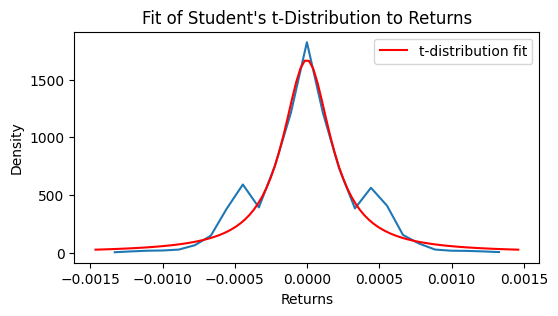

In [347]:
plt.figure(figsize=(6, 3))
plt.plot(bin_centers, hist)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
pdf = students_t_pdf(x, nu, mu, std)
plt.plot(x, pdf, 'r', label='t-distribution fit')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.title('Fit of Student\'s t-Distribution to Returns')
plt.legend()
plt.show()

In [348]:
t.rvs(nu, loc=mu, scale=std, size=5)

array([ 1.90825213e-03, -7.36162592e-05,  2.03280181e-05,  1.50717807e-05,
        6.56316073e-05])

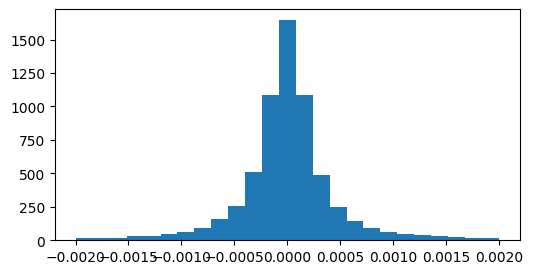

In [349]:
samples = t.rvs(df=nu, loc=mu, scale=std, size=len(returns))
samples = samples[(samples > -0.002) & (samples < 0.002)]

plt.figure(figsize=(6, 3))
plt.hist(samples, density=True, bins=n_bins)
plt.show()

In [350]:
def sample_log_return(size, df=nu, loc=mu, scale=std):
    return t.rvs(df=nu, loc=mu, scale=std, size=size)

In [351]:
def sample_prices(size):
    synth_log_returns = sample_log_return(size)
    synth_log_returns = synth_log_returns[(synth_log_returns > returns.min()) & (synth_log_returns < returns.max())]
    synthetic_price = np.cumprod(np.exp(synth_log_returns)) * 5000
    return synthetic_price

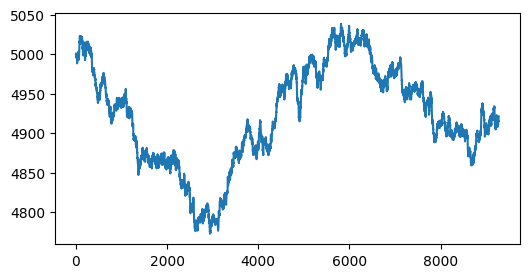

In [357]:
synthetic_price = sample_prices(10000)

plt.figure(figsize=(6, 3))
plt.plot(synthetic_price)
plt.show()

## BB 

### Train

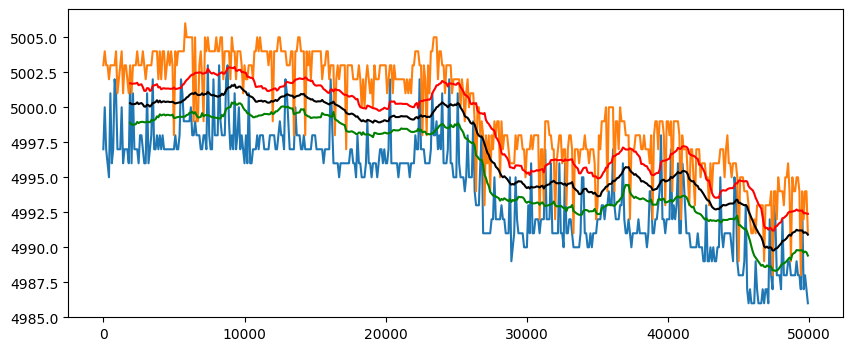

In [407]:
w_roll = 20
std_mul = 1

bid = ps1['bid_price_1']
ask = ps1['ask_price_1']
thr_h = ps1['mid_price'].rolling(w_roll).mean() + std_mul * ps1['mid_price'].rolling(w_roll).std()
thr_l = ps1['mid_price'].rolling(w_roll).mean() - std_mul * ps1['mid_price'].rolling(w_roll).std()
thr_mid = (thr_h + thr_l) / 2

plt.figure(figsize=(10, 4))
plt.plot(bid.iloc[:500])
plt.plot(ask.iloc[:500])
plt.plot(thr_h.iloc[:500], c='r')
plt.plot(thr_l.iloc[:500], c='g')
plt.plot(thr_mid.iloc[:500], c='k')
plt.show()

In [631]:
def calc_pnl(data, w_roll = 10, std_mul = 0):
    max_position = 20
    
    df = data.copy()
    df = df.assign(thr_h=lambda x: x['mid_price'].rolling(w_roll).mean() + std_mul * x['mid_price'].rolling(w_roll).std())
    df = df.assign(thr_l=lambda x: x['mid_price'].rolling(w_roll).mean() - std_mul * x['mid_price'].rolling(w_roll).std())
    df = df.assign(thr_m=lambda x: (x['thr_h'] + x['thr_l']) / 2)
    
    curr_position = 0
    pnl = 0
    traded_price = 0
    for idx, row in df.iterrows():
        if (curr_position == 0) and (row['ask_price_1'] <= row['thr_l']):
            curr_position = min(row['ask_volume_1'], max_position)
            traded_price = row['ask_price_1']
        if (curr_position == 0) and (row['bid_price_1'] >= row['thr_h']):
            curr_position = -min(row['bid_volume_1'], max_position)
            traded_price = row['bid_price_1']
        if (curr_position < 0) and (row['ask_price_1'] <= row['thr_m']):
            pnl += (row['ask_price_1'] - traded_price) * curr_position
            curr_position = 0
            traded_price = 0
        if (curr_position > 0) and (row['bid_price_1'] >= row['thr_m']):
            pnl += (row['bid_price_1'] - traded_price) * curr_position
            curr_position = 0
            traded_price = 0
    return pnl

In [ ]:
def calc_test_pnl(w_roll, std_mul):
    return (calc_pnl(ps2, w_roll, std_mul) + calc_pnl(ps3, w_roll, std_mul)) / 2

In [637]:
calc_pnl(ps1, w_roll = 10, std_mul = 0)

4689.0

In [562]:
%%time

max_position = 20

pnls = {}
for w_roll in range(1, 30):
    for std_mul in np.arange(-0.5, 1.1, 0.1):
        df = ps1.copy()
        df = df.assign(thr_h=lambda x: x['mid_price'].rolling(w_roll).mean() + std_mul * x['mid_price'].rolling(w_roll).std())
        df = df.assign(thr_l=lambda x: x['mid_price'].rolling(w_roll).mean() - std_mul * x['mid_price'].rolling(w_roll).std())
        df = df.assign(thr_m=lambda x: (x['thr_h'] + x['thr_l']) / 2)
        
        curr_position = 0
        pnl = 0
        traded_price = 0
        for idx, row in df.iterrows():
            if (curr_position == 0) and (row['ask_price_1'] <= row['thr_l']):
                curr_position = min(row['ask_volume_1'], max_position)
                traded_price = row['ask_price_1']
            if (curr_position == 0) and (row['bid_price_1'] >= row['thr_h']):
                curr_position = -min(row['bid_volume_1'], max_position)
                traded_price = row['bid_price_1']
            if (curr_position < 0) and (row['ask_price_1'] <= row['thr_m']):
                pnl += (row['ask_price_1'] - traded_price) * curr_position
                curr_position = 0
                traded_price = 0
            if (curr_position > 0) and (row['bid_price_1'] >= row['thr_m']):
                pnl += (row['bid_price_1'] - traded_price) * curr_position
                curr_position = 0
                traded_price = 0
        pnls[(w_roll, std_mul)] = pnl

CPU times: total: 3min 32s
Wall time: 3min 32s


In [563]:
max_pnl = max(pnls.values())
params = [k for k, v in pnls.items() if v == max_pnl]
print(f'w_roll: {params[0][0]}, std_mul: {params[0][1]}, profit: {max_pnl}')

w_roll: 3, std_mul: -0.20000000000000007, profit: 4963.0


In [564]:
b1_unique = np.unique(np.array([key[0] for key in pnls.keys()]))
b2_unique = np.unique(np.array([key[1] for key in pnls.keys()]))
x, y = np.meshgrid(b2_unique, b1_unique)
z = np.zeros(x.shape)
for i, xi in enumerate(b1_unique):
    for j, yi in enumerate(b2_unique):
        z[i, j] = pnls.get((xi, yi), 0)

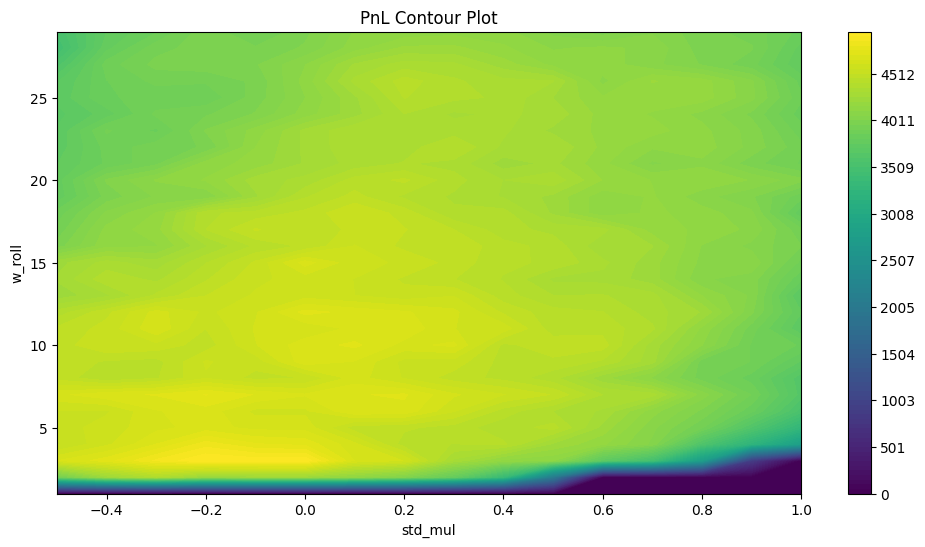

In [587]:
plt.figure(figsize=(12, 6))
plt.contourf(x, y, z, levels=np.linspace(z.min(), z.max(), 100), cmap='viridis')
plt.colorbar()
plt.title('PnL Contour Plot')
plt.xlabel('std_mul')
plt.ylabel('w_roll')
plt.show()

In [623]:
b1_opt = b1_unique[np.where(z == z.max())[0][0]]
b2_opt = b2_unique[np.where(z == z.max())[1][0]]
print('Best params: ', b1_opt, b2_opt)

Best params:  3 -0.20000000000000007


Best params:  9 -1.1102230246251565e-16


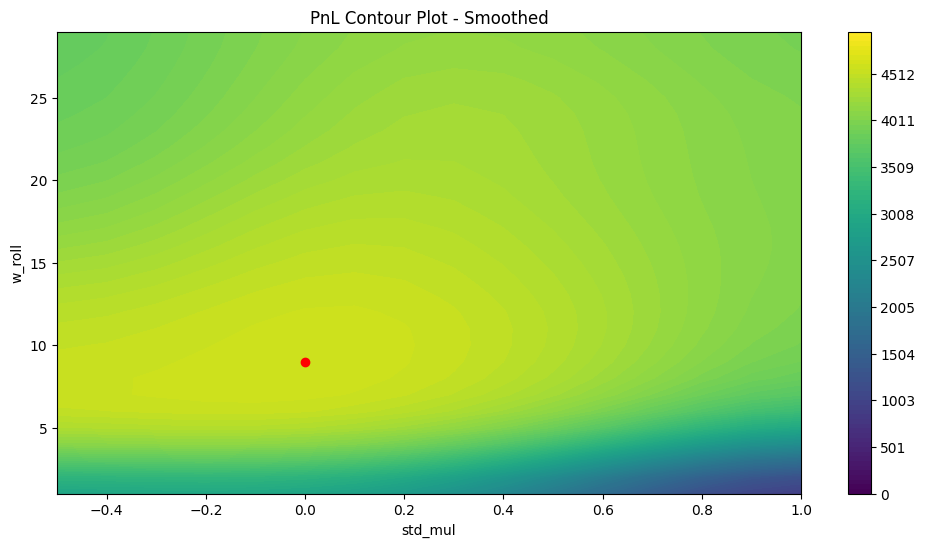

In [652]:
z_denoised = gaussian_filter(z, sigma=2.2)
b1_opt = b1_unique[np.where(z_denoised == z_denoised.max())[0][0]]
b2_opt = b2_unique[np.where(z_denoised == z_denoised.max())[1][0]]
print('Best params: ', b1_opt, b2_opt)

plt.figure(figsize=(12, 6))
plt.contourf(x, y, z_denoised, levels=np.linspace(z.min(), z.max(), 100), cmap='viridis')
plt.plot(b2_opt, b1_opt, 'ro')
plt.colorbar()
plt.title('PnL Contour Plot - Smoothed')
plt.xlabel('std_mul')
plt.ylabel('w_roll')
plt.show()

In [610]:
l_b1, l_b2 = [], []
sig_range = np.arange(0, 10, 0.01)
for sig in sig_range:
    z_denoised = gaussian_filter(z, sigma=sig)
    b1_opt = b1_unique[np.where(z_denoised == z_denoised.max())[0][0]]
    b2_opt = b2_unique[np.where(z_denoised == z_denoised.max())[1][0]]
    l_b1.append(b1_opt)
    l_b2.append(b2_opt)

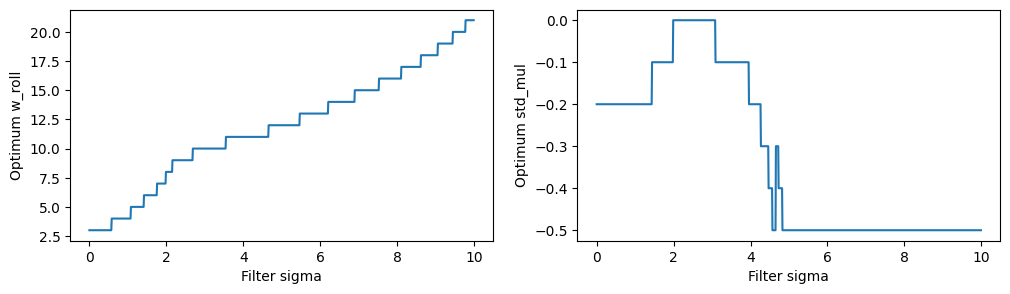

In [630]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].plot(sig_range, l_b1)
ax[0].set_xlabel('Filter sigma')
ax[0].set_ylabel('Optimum w_roll')
ax[1].plot(sig_range, l_b2, label='std_mul')
ax[1].set_xlabel('Filter sigma')
ax[1].set_ylabel('Optimum std_mul')
plt.show()

In [638]:
calc_pnl(ps1, w_roll = 10, std_mul = 0)

4689.0

In [646]:
test_pnls = []
sig_range = np.arange(0, 5, 0.1)
for sig in sig_range:
    z_denoised = gaussian_filter(z, sigma=sig)
    b1_opt = b1_unique[np.where(z_denoised == z_denoised.max())[0][0]]
    b2_opt = b2_unique[np.where(z_denoised == z_denoised.max())[1][0]]
    test_pnls.append(calc_test_pnl(b1_opt, b2_opt))

In [651]:
sig_range[np.argmax(test_pnls)]

2.2

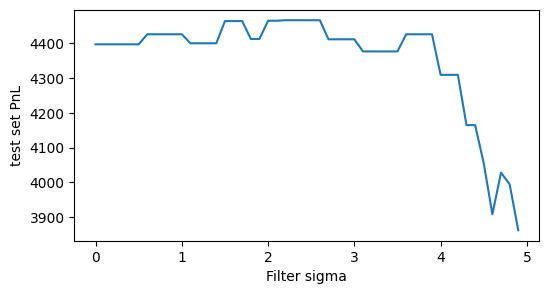

In [647]:
plt.figure(figsize=(6, 3))
plt.plot(sig_range, test_pnls)
plt.xlabel('Filter sigma')
plt.ylabel('test set PnL')
plt.show()

- **Best MA period: 9**
- **Best STD multiple: 0**

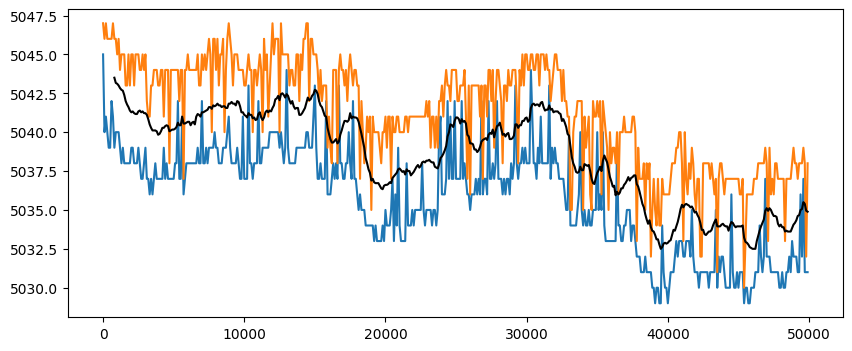

In [820]:
w_roll = 9

bid = ps2['bid_price_1']
ask = ps2['ask_price_1']
mid_ma = ps2['mid_price'].rolling(w_roll).mean()

plt.figure(figsize=(10, 4))
plt.plot(bid.iloc[:500])
plt.plot(ask.iloc[:500])
plt.plot(mid_ma.iloc[:500], c='k')
plt.show()

In [815]:
mid_ma.dropna()[mid_ma.dropna() % 1 == 0].head(3)

timestamp
1100    5043.0
1600    5042.0
5600    5041.0
Name: mid_price, dtype: float64

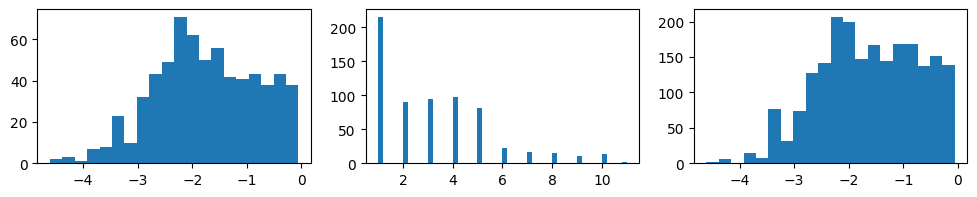

In [807]:
dif = (ps2['ask_price_1'] - mid_ma).dropna()
fig, ax = plt.subplots(1, 3, figsize=(12, 2))
ax[0].hist(dif[dif < 0], bins=20)
ax[1].hist(ps2.loc[dif[dif < 0].index]['ask_volume_1'], bins=50)
ax[2].hist(dif[dif < 0], bins=20, weights=ps2.loc[dif[dif < 0].index]['ask_volume_1'])
plt.show()

4.582504750123306 -5.485036108711638 4.095643508600283


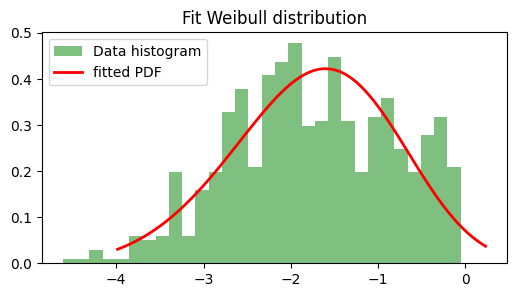

In [808]:
c, loc, scale = weibull_min.fit(dif[dif < 0])
x = np.linspace(weibull_min.ppf(0.01, c, loc=loc, scale=scale),
                weibull_min.ppf(0.99, c, loc=loc, scale=scale), 100)
print(c, loc, scale)

plt.figure(figsize=(6, 3))
plt.hist(dif[dif < 0], bins=30, density=True, alpha=0.5, color='g', label='Data histogram')
plt.plot(x, weibull_min.pdf(x, c, loc=loc, scale=scale), 'r-', lw=2, label='fitted PDF')
plt.title('Fit Weibull distribution')
plt.legend()
plt.show()

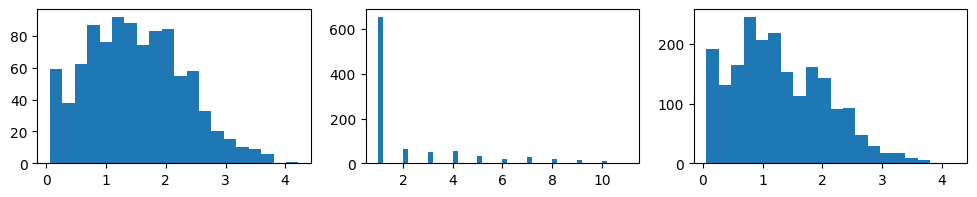

In [809]:
dif = (ps2['bid_price_1'] - mid_ma).dropna()
fig, ax = plt.subplots(1, 3, figsize=(12, 2))
ax[0].hist(dif[dif > 0], bins=20)
ax[1].hist(ps2.loc[dif[dif > 0].index]['bid_volume_1'], bins=50)
ax[2].hist(dif[dif > 0], bins=20, weights=ps2.loc[dif[dif > 0].index]['bid_volume_1'])
plt.show()

2.1774123605874367 -0.16919848789610595 1.8858953893955785


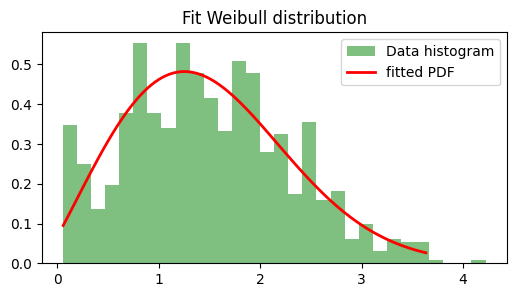

In [810]:
c, loc, scale = weibull_min.fit(dif[dif > 0])
x = np.linspace(weibull_min.ppf(0.01, c, loc=loc, scale=scale),
                weibull_min.ppf(0.99, c, loc=loc, scale=scale), 100)
print(c, loc, scale)

plt.figure(figsize=(6, 3))
plt.hist(dif[dif > 0], bins=30, density=True, alpha=0.5, color='g', label='Data histogram')
plt.plot(x, weibull_min.pdf(x, c, loc=loc, scale=scale), 'r-', lw=2, label='fitted PDF')
plt.title('Fit Weibull distribution')
plt.legend()
plt.show()